In [2]:
import os
import uuid
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, activations, out_dim):
        super().__init__()
        layers, dims = [], [in_dim] + hidden_dims
        for i, h in enumerate(hidden_dims):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act = activations[i].lower()
            if   act=='relu':     layers.append(nn.ReLU())
            elif act=='tanh':     layers.append(nn.Tanh())
            elif act=='sigmoid':  layers.append(nn.Sigmoid())
            elif act=='softplus': layers.append(nn.Softplus())
            else: raise ValueError(f"Unknown activation '{activations[i]}'")
        layers.append(nn.Linear(dims[-1], out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def cross_validate_mlp(
    csv_path: str,
    k_folds: int,
    layer_dims: list[int],
    activations: list[str],
    epochs: int,
    lr: float,
    weight_decay: float,
    batch_size: int,
    random_state: int,
    loss_type: str = 'mse',
    loss_weights: list[float] = [1.0, 1.0],
    include_ratio_features: bool = True,
    save_results: bool = False
):
    """
    2-output MLP CV but only prints & plots metrics/scatter for the first output.
    """
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # ─── Load & preprocess ─────────────────────────────────────────────────────
    df = pd.read_csv(csv_path)
    output_cols = df.columns[:2].tolist()
    inputs = df.columns[2:].tolist()
    num_cols, cat_col = inputs[:-1], inputs[-1]

    # optionally drop ratio features
    ratio_cols = ['Proppant.per.GPI..lb.ft.', 'Fluid.per.GPI..gal.ft.']
    if not include_ratio_features:
        num_cols = [c for c in num_cols if c not in ratio_cols]

    # targets
    y = df[output_cols].to_numpy(dtype=np.float32)
    y_mean = y.mean(axis=0, keepdims=True)
    y_std  = y.std(axis=0, keepdims=True)
    y_std[y_std==0] = 1.0
    y_norm = (y - y_mean) / y_std

    # numeric inputs
    X_num = df[num_cols].astype(float).copy()
    x_mean = X_num.mean()
    x_std  = X_num.std().replace(0,1.0)
    X_num = (X_num - x_mean) / x_std

    # categorical
    X_cat = pd.get_dummies(df[cat_col].astype(str), prefix=cat_col)
    X = pd.concat([X_num, X_cat], axis=1)
    feature_names = X.columns.tolist()
    X_np = X.to_numpy(dtype=np.float32)

    # weighted per-output loss
    w = torch.tensor(loss_weights, device=device).view(1,-1)
    def loss_fn(pred, true):
        if loss_type=='mse':
            err = (pred - true)**2
        else:
            err = nn.functional.smooth_l1_loss(pred, true, reduction='none')
        return (err * w).mean()

    # ─── Cross-Validation ──────────────────────────────────────────────────────
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    fold_results, histories, models = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_np), start=1):
        X_tr, X_va = X_np[tr_idx], X_np[va_idx]
        y_tr, y_va = y_norm[tr_idx], y_norm[va_idx]

        ds_tr = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=batch_size)

        model = MLP(X_tr.shape[1], layer_dims, activations, y_tr.shape[1]).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        tr_losses, va_losses, tr_r2s, va_r2s = [], [], [], []

        for epoch in range(1, epochs+1):
            # training
            model.train()
            for xb, yb in ld_tr:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                loss = loss_fn(model(xb), yb)
                loss.backward()
                opt.step()

            # evaluation
            model.eval()
            with torch.no_grad():
                p_tr = model(torch.from_numpy(X_tr).to(device))
                p_va = model(torch.from_numpy(X_va).to(device))
                l_tr = loss_fn(p_tr, torch.from_numpy(y_tr).to(device)).item()
                l_va = loss_fn(p_va, torch.from_numpy(y_va).to(device)).item()

            p_tr_np = p_tr.cpu().numpy()
            p_va_np = p_va.cpu().numpy()

            tr_losses.append(l_tr)
            va_losses.append(l_va)
            # record only output1 R² per epoch
            tr_r2s.append(r2_score(y_tr[:,0], p_tr_np[:,0]))
            va_r2s.append(r2_score(y_va[:,0], p_va_np[:,0]))

        # un-normalize for final metrics
        yt_tr = y_tr[:,0] * y_std[0,0] + y_mean[0,0]
        yp_tr = p_tr_np[:,0] * y_std[0,0] + y_mean[0,0]
        yt_va = y_va[:,0] * y_std[0,0] + y_mean[0,0]
        yp_va = p_va_np[:,0] * y_std[0,0] + y_mean[0,0]

        r2_tr1 = r2_score(yt_tr, yp_tr)
        r2_va1 = r2_score(yt_va, yp_va)

        # only print R²1
        print(f"Fold {fold}: train R²1={r2_tr1:.4f}, val R²1={r2_va1:.4f}")

        fold_results.append({
            'fold': fold,
            'train_true': yt_tr, 'train_pred': yp_tr,
            'val_true':   yt_va, 'val_pred':   yp_va
        })
        histories.append((tr_losses, va_losses, tr_r2s, va_r2s))
        models.append(model)

    norms = {
        'y_mean': float(y_mean[0,0]),
        'y_std':  float(y_std[0,0]),
        'x_mean': x_mean.to_dict(),
        'x_std':  x_std.to_dict(),
    }

    # ─── Diagnostic plots (3 cols per fold) ─────────────────────────────────
    fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4 * k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, fold_results)):
        ax_loss  = axes[i,0]
        ax_tr_sc = axes[i,1]
        ax_va_sc = axes[i,2]
        fold = fr['fold']

        # Loss vs Epoch
        ax_loss.plot(range(1, epochs+1), tr_losses, label='train')
        ax_loss.plot(range(1, epochs+1), va_losses, label='val')
        ax_loss.set_title(f'Fold {fold} Loss vs Epoch')
        ax_loss.set_ylabel('Weighted Loss')
        ax_loss.legend()

        # Train scatter (output1)
        yt_tr = fr['train_true']; yp_tr = fr['train_pred']
        ax_tr_sc.scatter(yt_tr, yp_tr, s=20, alpha=0.6)
        mn, mx = min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())
        ax_tr_sc.plot([mn,mx],[mn,mx],'k--')
        ax_tr_sc.set_title(f'Fold {fold} Out1 Train')
        ax_tr_sc.set_xlabel('True Out1'); ax_tr_sc.set_ylabel('Pred Out1')

        # Val scatter (output1)
        yt_va = fr['val_true']; yp_va = fr['val_pred']
        ax_va_sc.scatter(yt_va, yp_va, s=20, alpha=0.6)
        mn, mx = min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())
        ax_va_sc.plot([mn,mx],[mn,mx],'k--')
        ax_va_sc.set_title(f'Fold {fold} Out1 Val')
        ax_va_sc.set_xlabel('True Out1'); ax_va_sc.set_ylabel('Pred Out1')

    plt.tight_layout()
    plt.show()

    # optionally save models, hyperparams, norms...
    if save_results:
        tag = uuid.uuid4().hex[:8]
        os.makedirs(tag, exist_ok=True)
        for i, m in enumerate(models, start=1):
            torch.save(m.state_dict(), os.path.join(tag, f"{tag}_fold{i}.pth"))
        meta = {
            "csv_path": csv_path, "k_folds": k_folds,
            "layer_dims": layer_dims, "activations": activations,
            "epochs": epochs, "lr": lr, "weight_decay": weight_decay,
            "batch_size": batch_size, "random_state": random_state,
            "loss_type": loss_type, "loss_weights": loss_weights,
            "include_ratio_features": include_ratio_features
        }
        with open(os.path.join(tag, f"{tag}_hyperparams.json"), 'w') as f:
            json.dump(meta, f, indent=4)
        with open(os.path.join(tag, f"{tag}_norms.json"), 'w') as f:
            json.dump(norms, f, indent=4)
        print(f"Saved results under ./{tag}/")

    return fold_results, histories, models, norms, feature_names


# relu

Fold 1: train R²1=0.8784, val R²1=0.7675
Fold 2: train R²1=0.8894, val R²1=0.6102
Fold 3: train R²1=0.8810, val R²1=0.6947
Fold 4: train R²1=0.8737, val R²1=0.6744
Fold 5: train R²1=0.8830, val R²1=0.5993
Fold 6: train R²1=0.8717, val R²1=0.7535
Fold 7: train R²1=0.8822, val R²1=0.4610


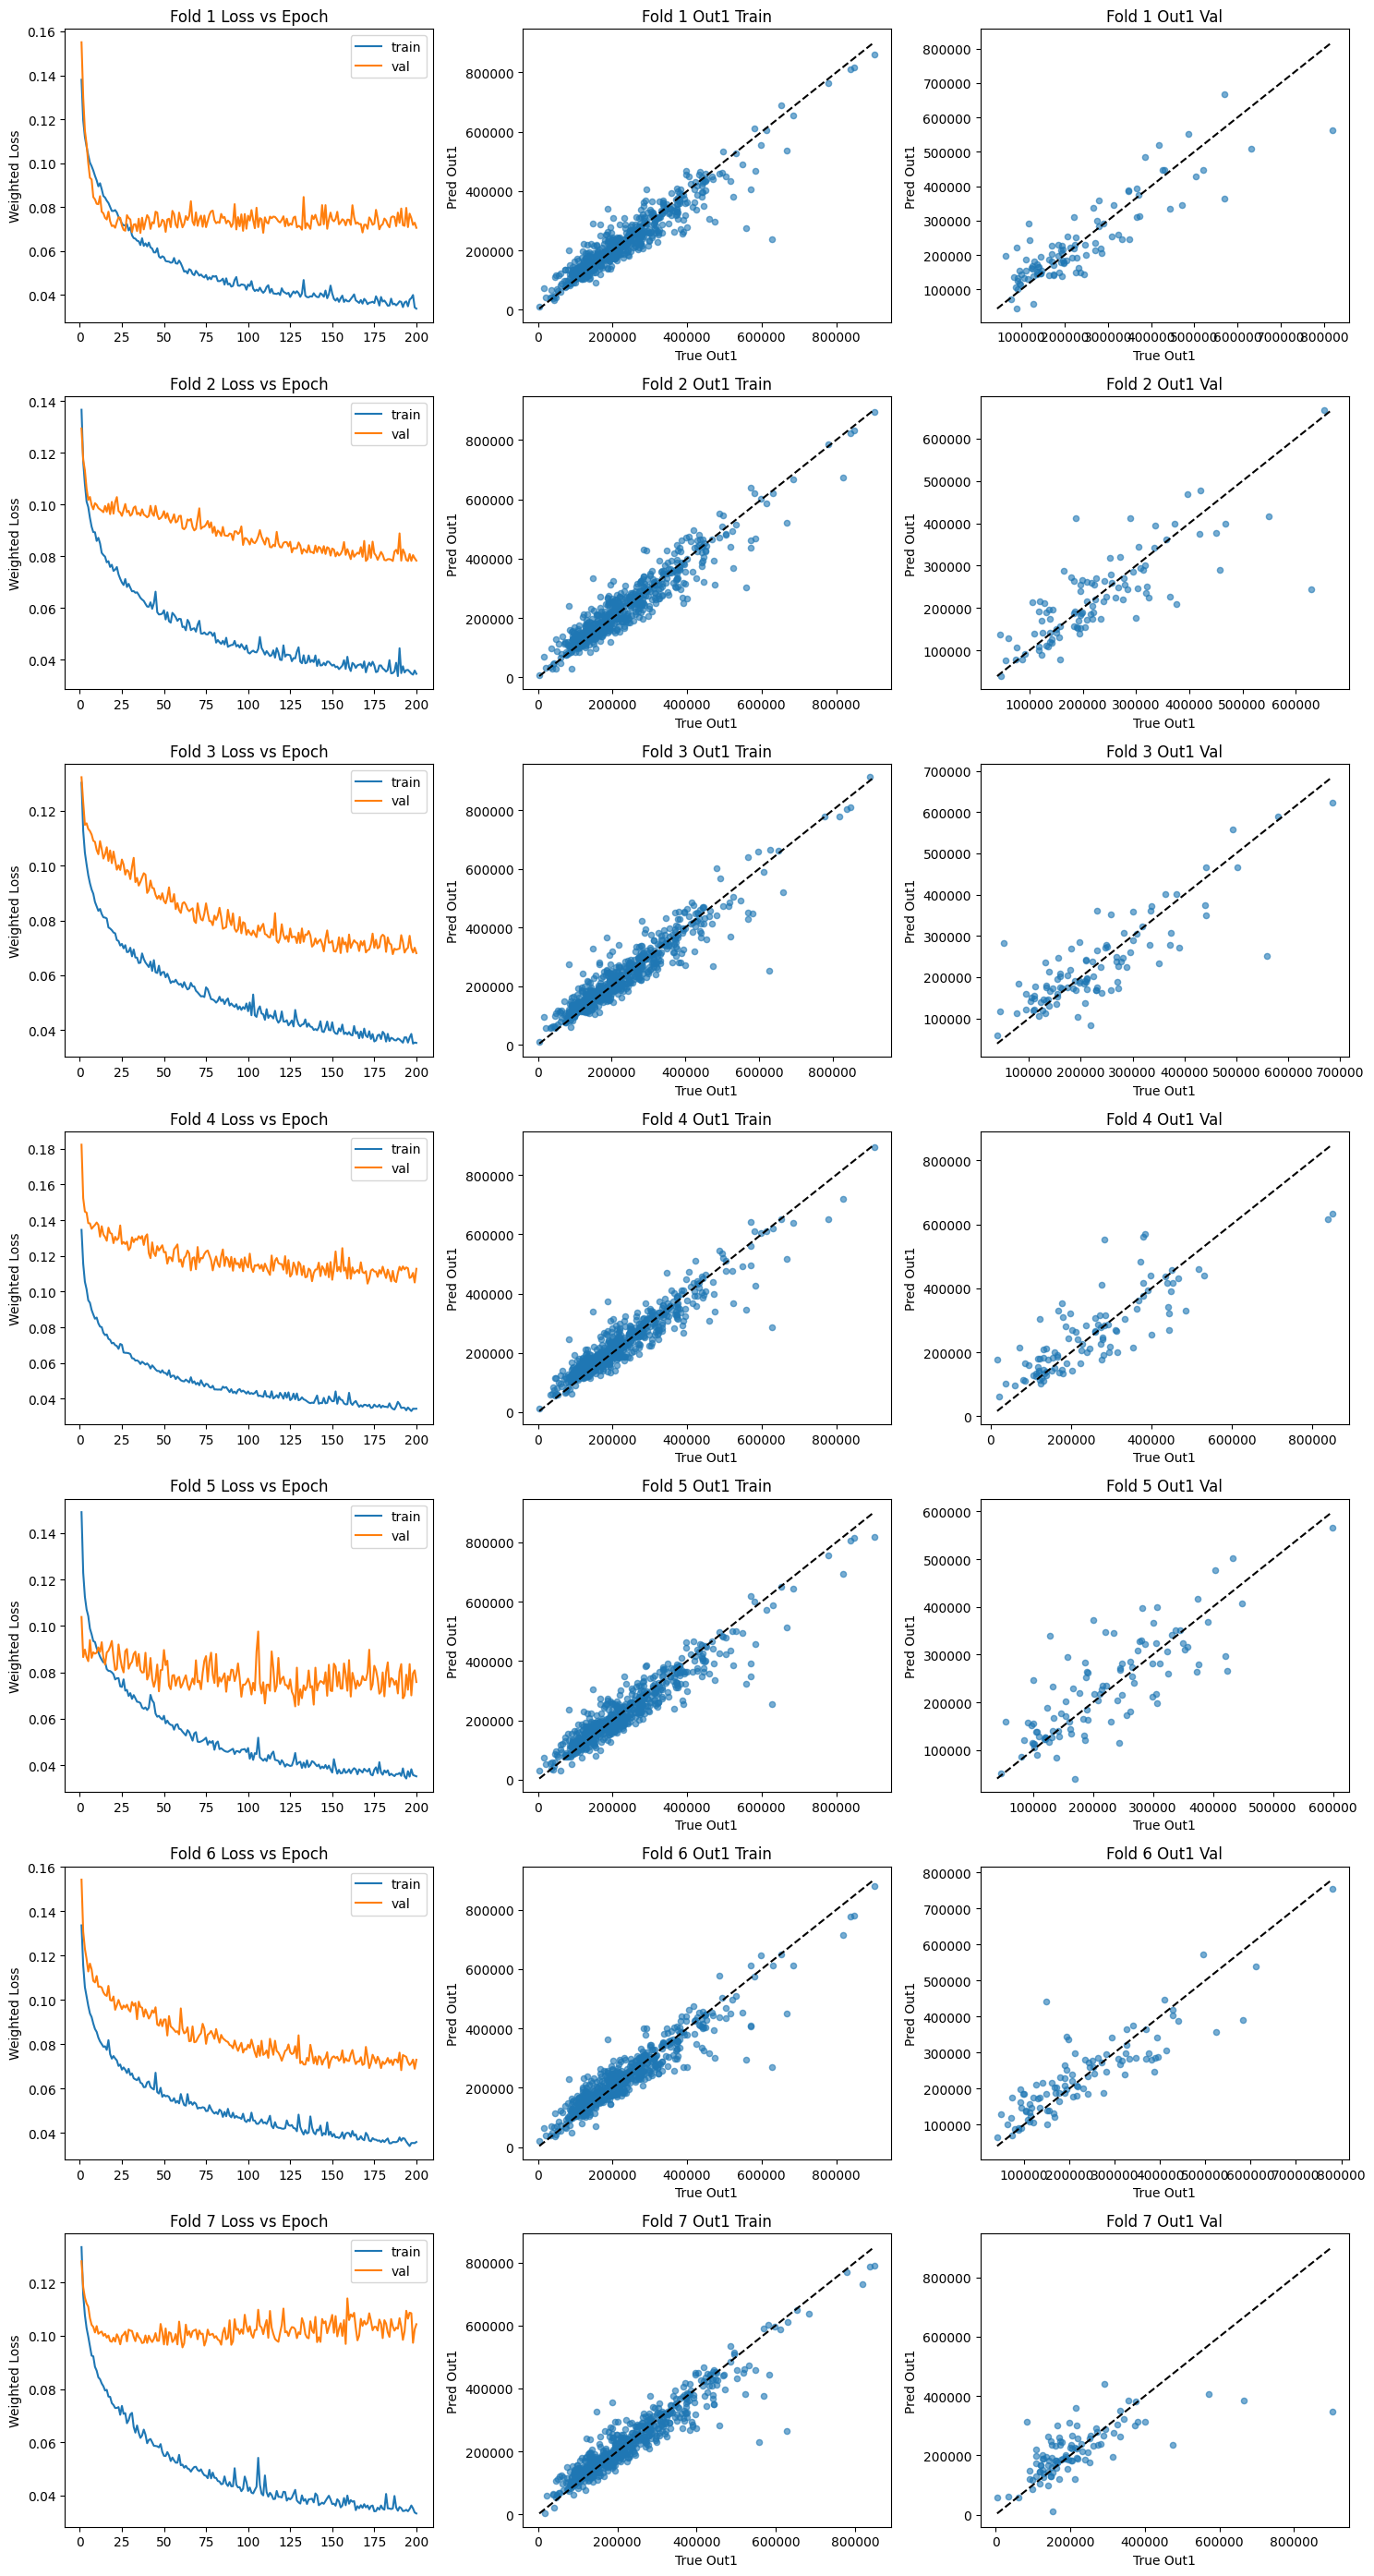

Saved results under ./d3feed88/


In [36]:
res = cross_validate_mlp(
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv',
    k_folds = 7,
    layer_dims    = [64,256],
    activations   = ['tanh', 'relu'],
    epochs        = 200,
    lr            = 5e-4,
    weight_decay  = 60e-5,
    batch_size    = 16,
    random_state = 42,
    loss_type = 'huber',
    save_results = True,
    loss_weights = [1.0, 1.0e-1],
    include_ratio_features = True,
)


# softplus

Fold 1: train R²1=0.8020, val R²1=0.7781
Fold 2: train R²1=0.8347, val R²1=0.5576
Fold 3: train R²1=0.8217, val R²1=0.6595
Fold 4: train R²1=0.8130, val R²1=0.6411
Fold 5: train R²1=0.8020, val R²1=0.4511
Fold 6: train R²1=0.8223, val R²1=0.7278
Fold 7: train R²1=0.8346, val R²1=0.4933


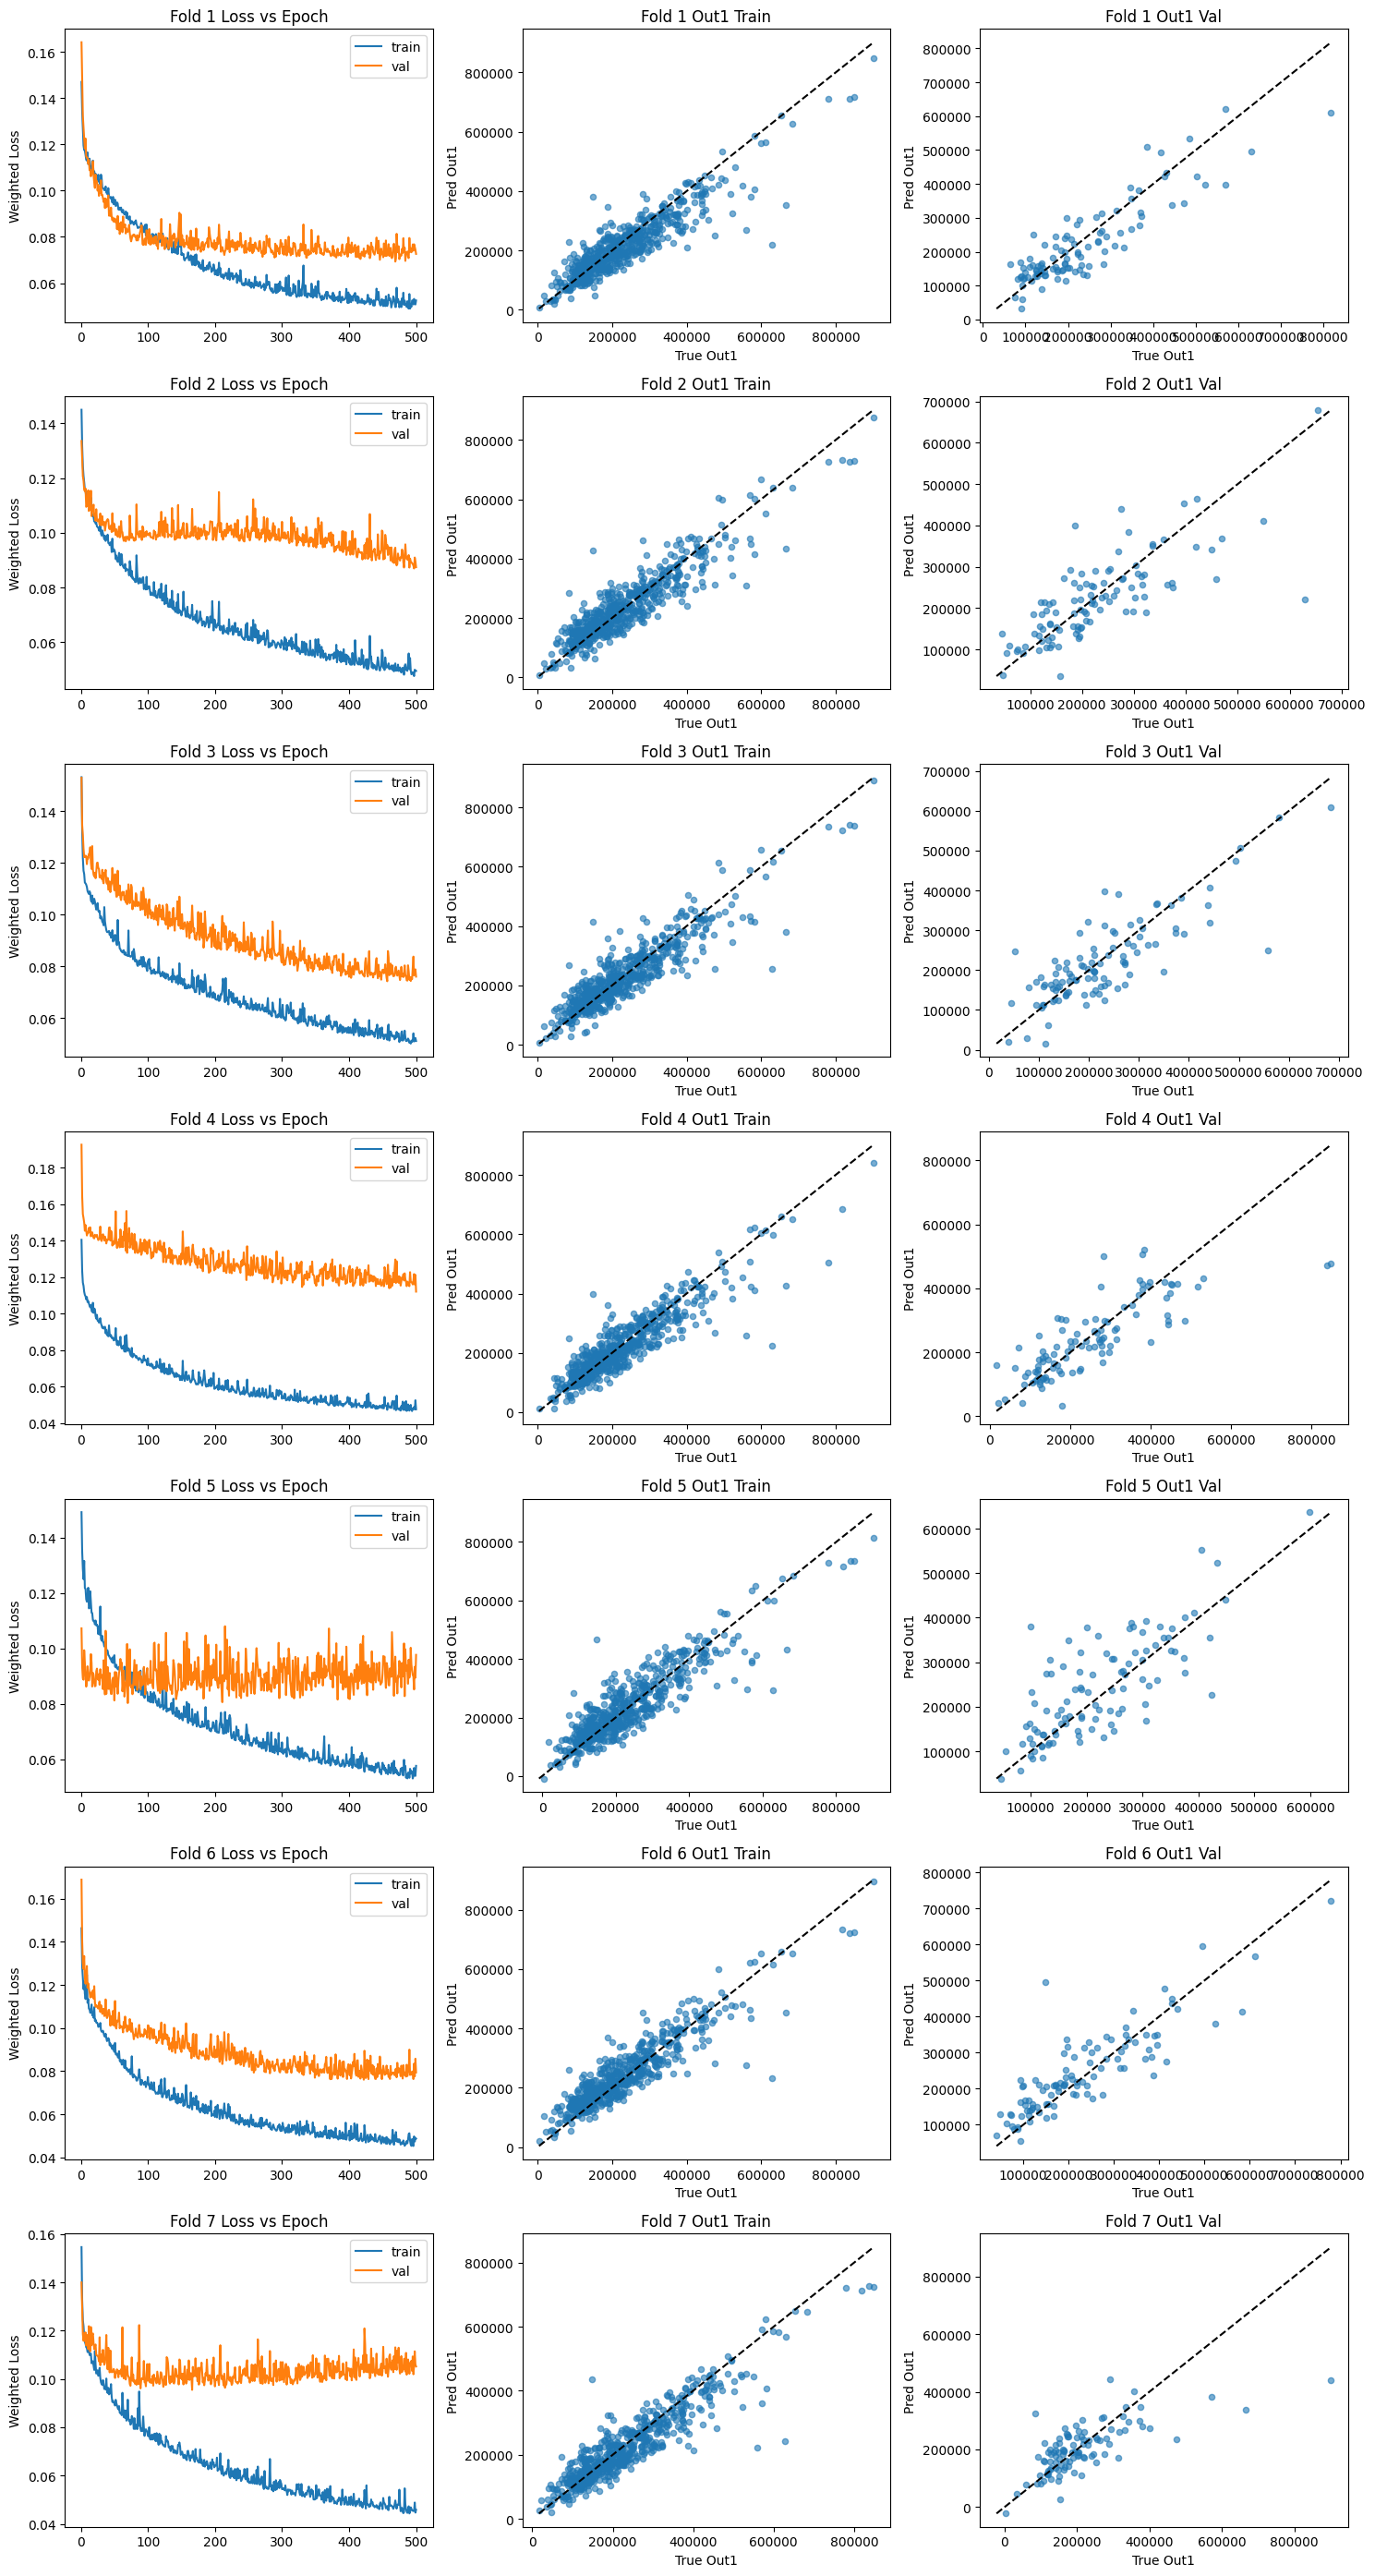

Saved results under ./4eb5e823/


In [38]:
res = cross_validate_mlp(
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv',
    k_folds = 7,
    layer_dims    = [64,256],
    activations   = ['tanh', 'softplus'],
    epochs        = 500,
    lr            = 5e-4,
    weight_decay  = 80e-5,
    batch_size    = 16,
    random_state = 42,
    loss_type = 'huber',
    save_results = True,
    loss_weights = [1.0, 1.0e-1],
    include_ratio_features = True,
)


# remove redundant relu

Fold 1: train R²1=0.8626, val R²1=0.7438
Fold 2: train R²1=0.8751, val R²1=0.5797
Fold 3: train R²1=0.8637, val R²1=0.6843
Fold 4: train R²1=0.8284, val R²1=0.6257
Fold 5: train R²1=0.8558, val R²1=0.6438
Fold 6: train R²1=0.8580, val R²1=0.7716
Fold 7: train R²1=0.8668, val R²1=0.5717


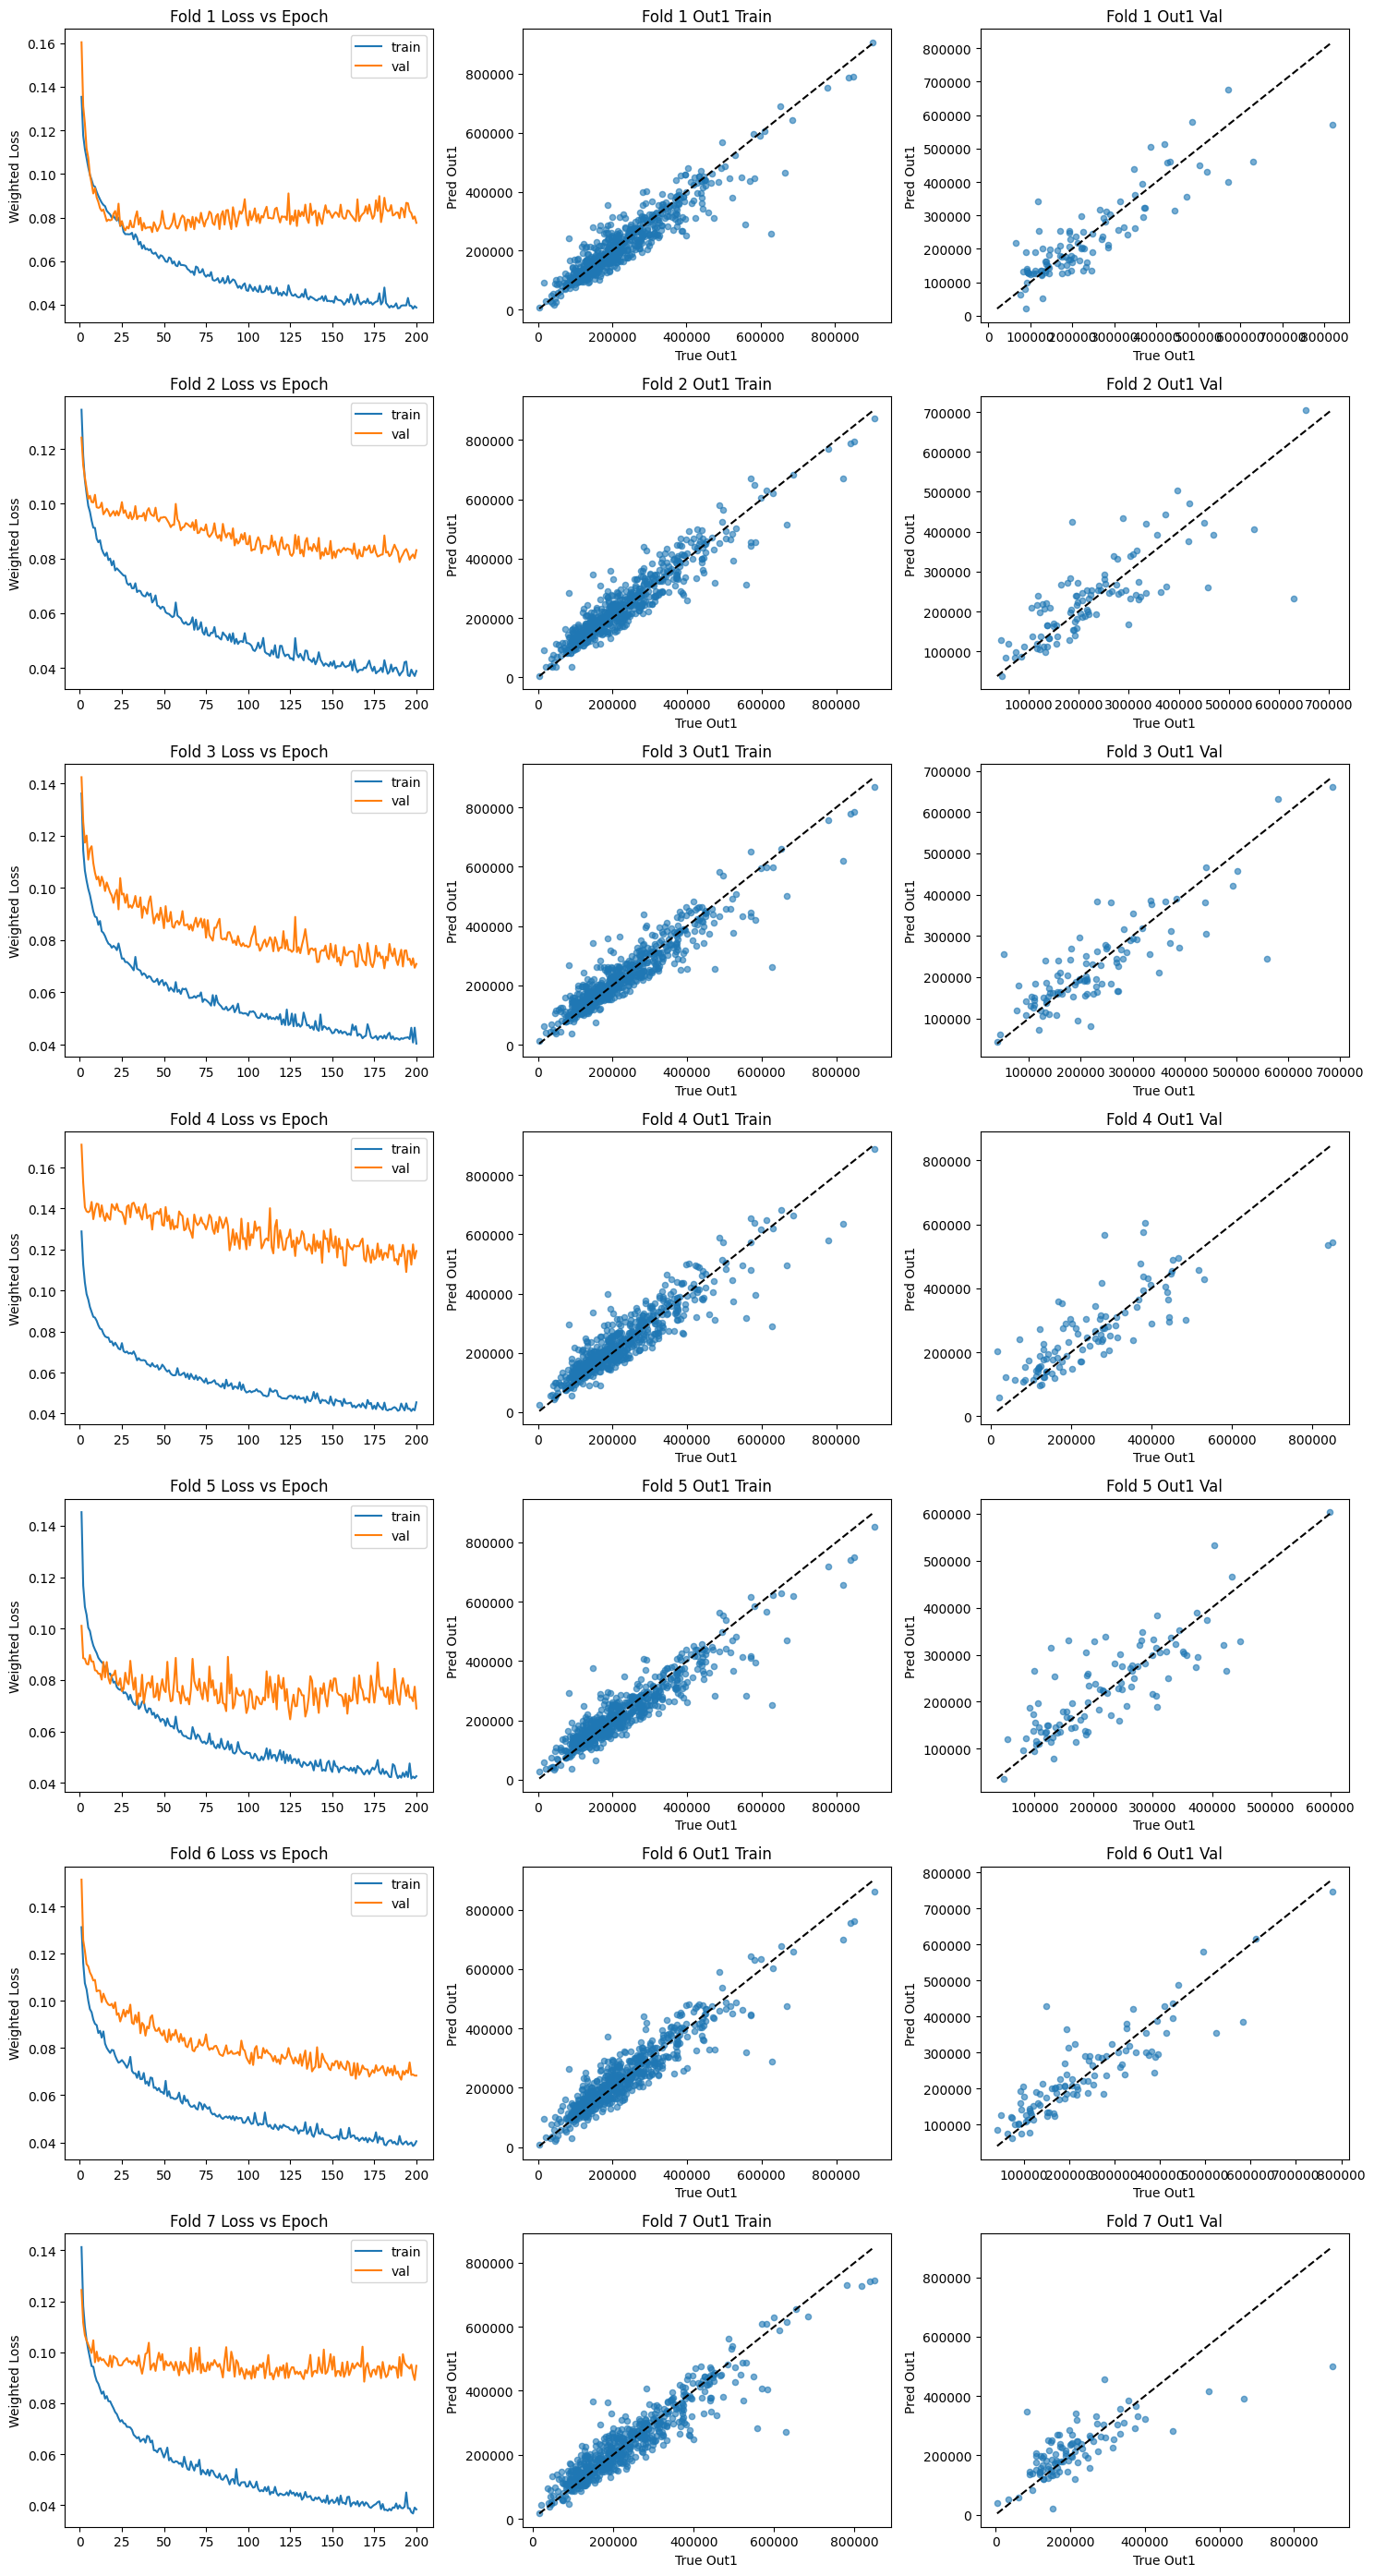

Saved results under ./5044f3a3/


In [48]:
res = cross_validate_mlp(
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv',
    k_folds = 7,
    layer_dims    = [64,256],
    activations   = ['tanh', 'relu'],
    epochs        = 200,
    lr            = 5e-4,
    weight_decay  = 80e-5,
    batch_size    = 16,
    random_state = 42,
    loss_type = 'huber',
    save_results = True,
    loss_weights = [1.0, 1.0e-1],
    include_ratio_features = False,
)


# removed redunt softplus


Fold 1: train R²1=0.7894, val R²1=0.7503
Fold 2: train R²1=0.8336, val R²1=0.5372
Fold 3: train R²1=0.7981, val R²1=0.6429
Fold 4: train R²1=0.8020, val R²1=0.6553
Fold 5: train R²1=0.8041, val R²1=0.6219
Fold 6: train R²1=0.8112, val R²1=0.7297
Fold 7: train R²1=0.8212, val R²1=0.5529


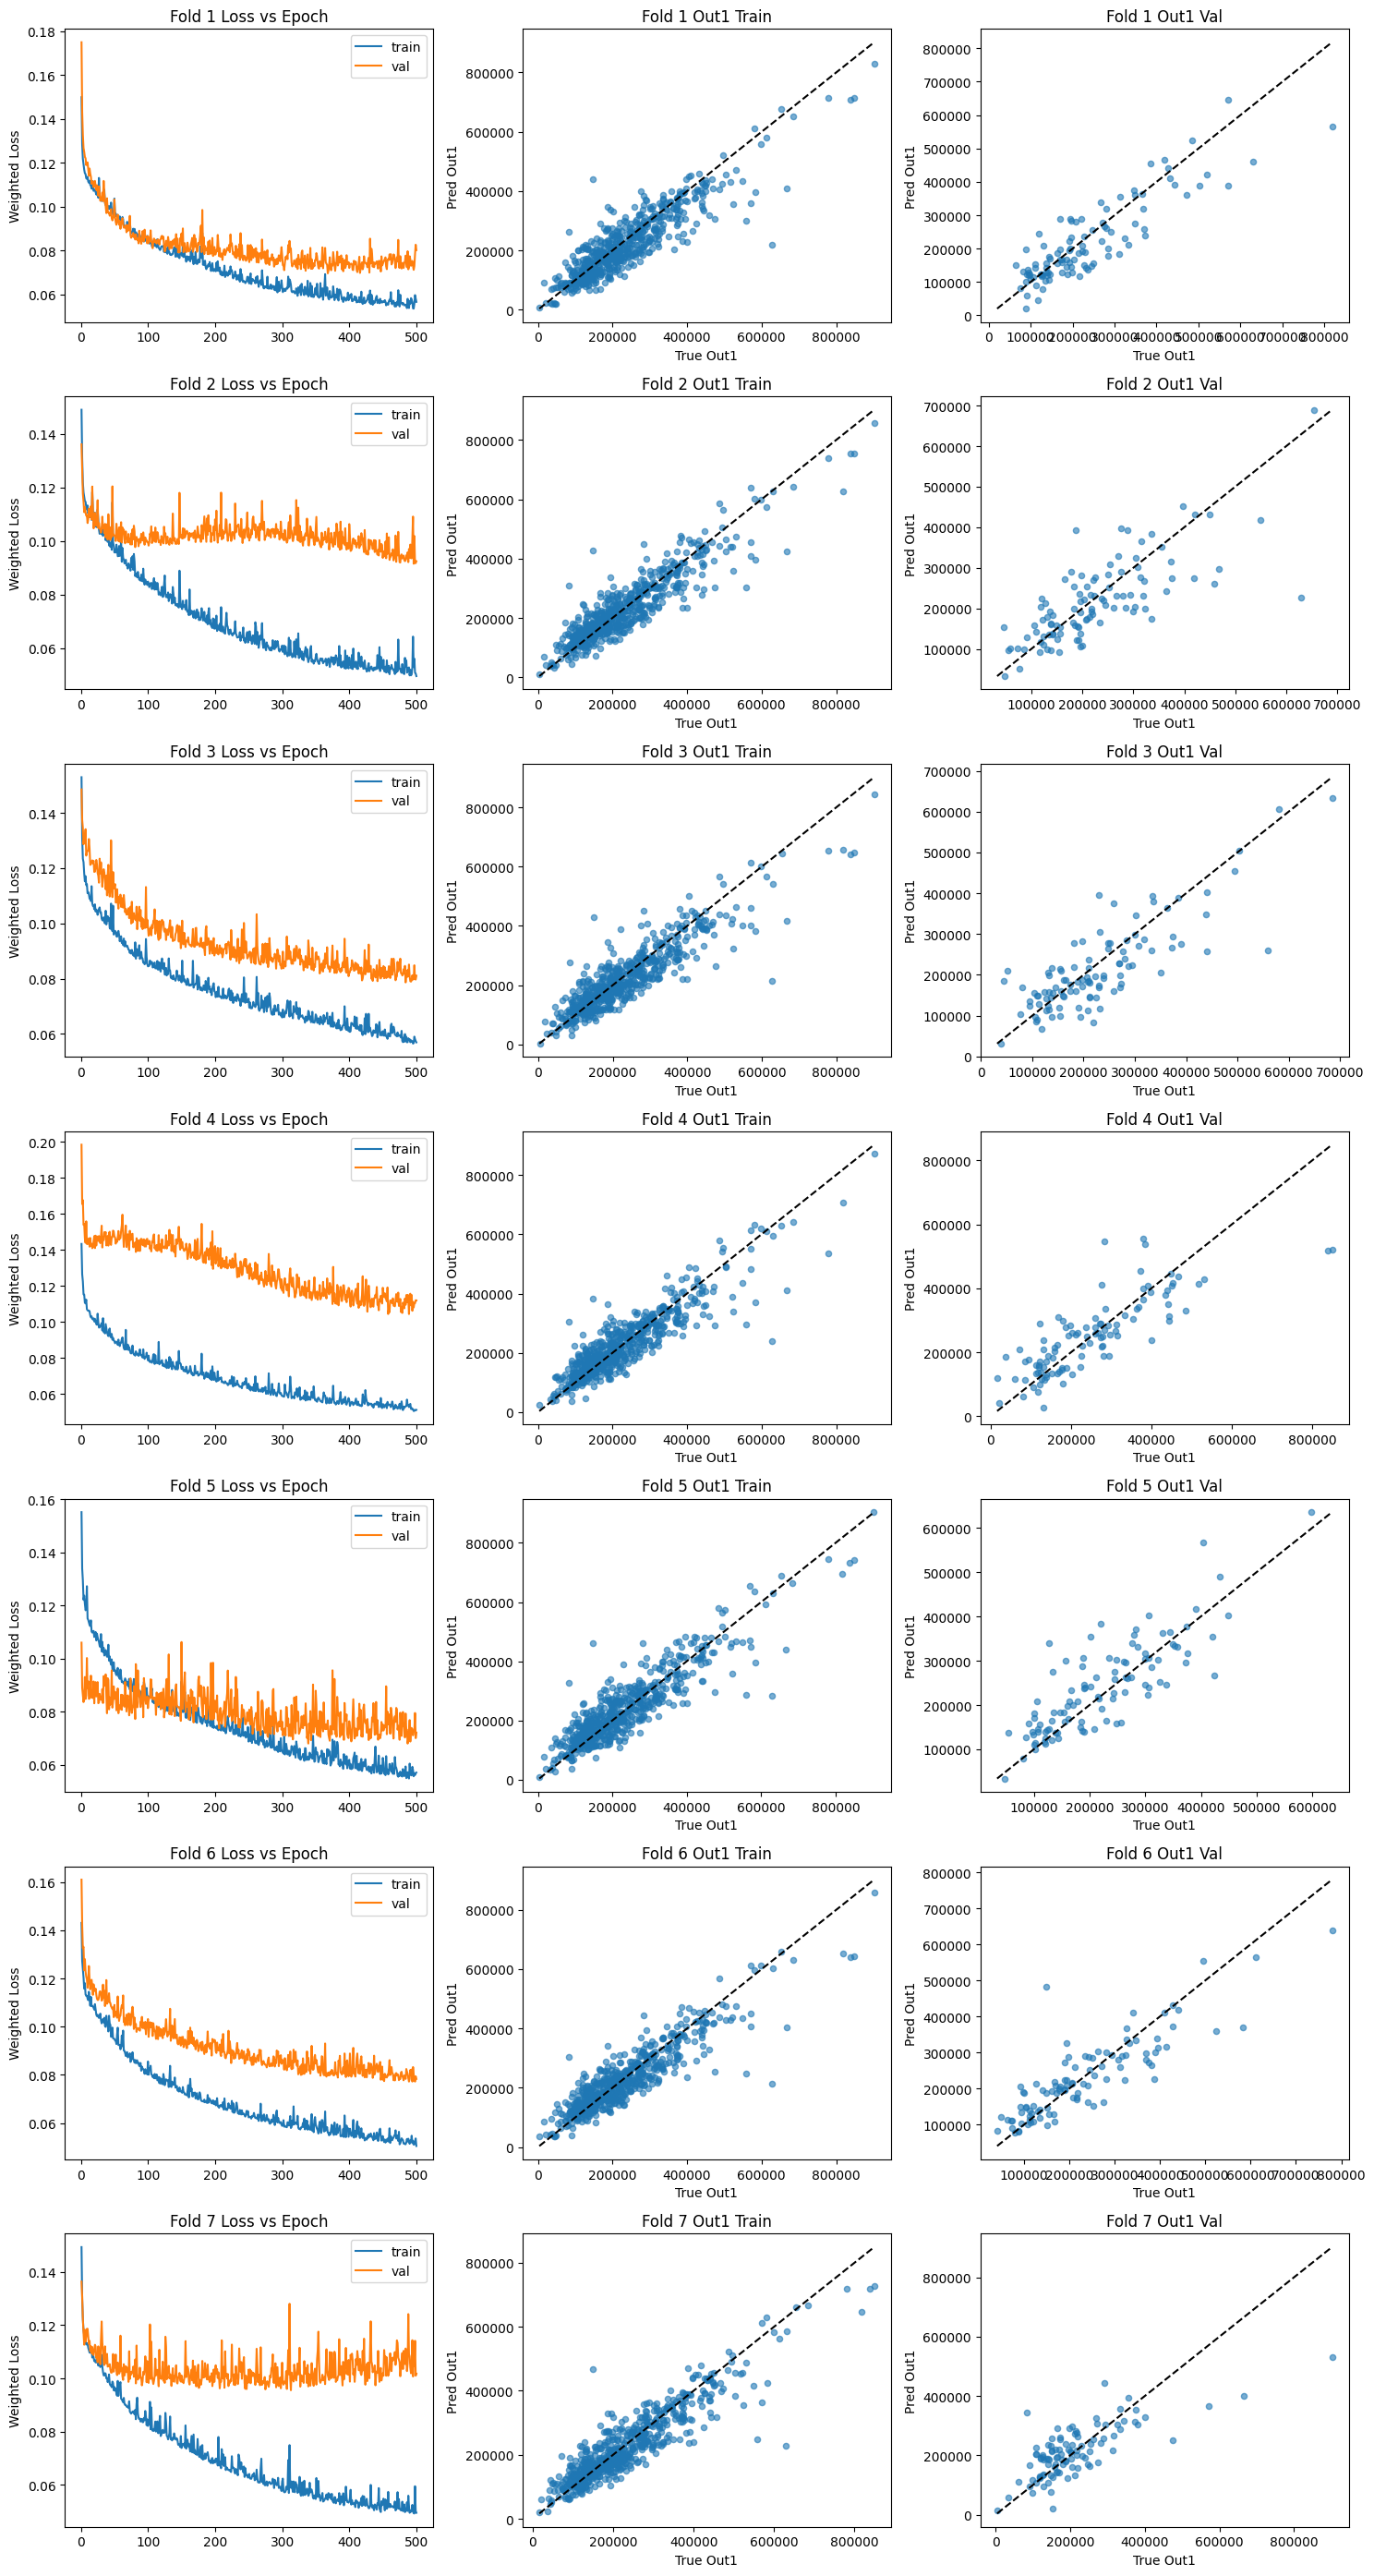

Saved results under ./98a1fcb5/


In [54]:
res = cross_validate_mlp(
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv',
    k_folds = 7,
    layer_dims    = [64,256],
    activations   = ['tanh', 'softplus'],
    epochs        = 500,
    lr            = 5e-4,
    weight_decay  = 80e-5,
    batch_size    = 16,
    random_state = 42,
    loss_type = 'huber',
    save_results = True,
    loss_weights = [1.0, 1.0e-1],
    include_ratio_features = False,
)
